##<font color='#4bcffa'> Momentum Strategy: Time Series Momentum: <br> 

<font color='#4bcffa'> Input<br>
<font color='#2bcbba'> Log returns (logarithmic) or continuously compounded return  <br>
Time period <br>
Boolean logic - determine if to take a short position<br>

<font color='#ef5777'> This strategy can evolve by using a series of indicators

In [1]:
import yfinance as yf 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import vectorbt as vbt

<font color='#4bcffa'>Time Momentum Strategy Function <br>
<font color='#2bcbba'>  Use log returns of the time series, indicate the time-period, logic to determine if a short position would be taken.<br>
The strategy returns Cumulative Sum --> this is used to monitor small shifts in the process mean. It uses the cumulative sum of deviations from a target.

In [2]:
def TS_momentum_strategy(returns, period=1, shorts=False):
  """1 day lookback """
  if shorts:
    position = returns.rolling(period).mean().map(
        lambda x: -1 if x <= 0 else 1
    )
  else:
    position = returns.rolling(period).mean().map(
        lambda x: 0 if x <= 0 else 1
    )
  performance = position.shift(1) * returns
  return performance 

<font color='#2bcbba'> Input: Get all the Historical Market Data from yahoo finance for NIO

In [3]:
ticker = 'BTC-USD' 
ticker_object = yf.Ticker(ticker)
ticker_data = ticker_object.history(start='2023-01-01')

In [28]:
ticker_data.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
230,2023-08-19 00:00:00+00:00,26047.832031,26249.449219,25802.408203,26096.205078,10631443812,0.0,0.0
231,2023-08-20 00:00:00+00:00,26096.861328,26260.681641,26004.314453,26189.583984,9036580420,0.0,0.0
232,2023-08-21 00:00:00+00:00,26188.691406,26220.201172,25846.087891,26124.140625,13371557893,0.0,0.0
233,2023-08-22 00:00:00+00:00,26130.748047,26135.507812,25520.728516,26031.656250,14503820706,0.0,0.0
234,2023-08-23 00:00:00+00:00,26083.507812,26143.343750,25906.871094,25938.628906,16121426944,0.0,0.0


<font color='#2bcbba'> We have the data but it would be best if we don't pass this to our strategy immediately; calculate the log returns first and then feed it into the strategy function

In [5]:
returns = np.log(ticker_data['Close'] / ticker_data['Close'].shift(1)).dropna() 

<font color='#2bcbba'>Considering momentum; the logic would be based on 'buy' if the trend is upward and 'sell' if the trend is downward (if you are holding). 

In [6]:
performance = TS_momentum_strategy(returns, period=1, shorts=False).dropna()
years = (performance.index.max() - performance.index.min()).days / 365 
perf_cum = np.exp(performance.cumsum()) 
tot = perf_cum[-1] -1 
ann = perf_cum[-1] ** (1 / years) - 1
vol = performance.std() * np.sqrt(252) 
#risk free rate - does not exist in reality - all investments have some degree of at least a very small risk 
rfr = 0.02 
sharpe = (ann - rfr) / vol

print(f"1-day Time Series Momentum generated: " +
      f"\n\ttotal returns: {tot*100:.2f}% " + 
      f"\n\tannual returns: {ann*100:.2f}% " +
      f"\n\tSharpe ratio: {sharpe:.2f} ")

1-day Time Series Momentum generated: 
	total returns: 39.67% 
	annual returns: 69.16% 
	Sharpe ratio: 2.23 


In [7]:
#BUY AND HOLD 
nio_returns = np.exp(returns.cumsum()) 
BH_tot = nio_returns[-1] -1 
BH_ann = nio_returns[-1] ** (1 / years) - 1
BH_vol = returns.std() * np.sqrt(252) 
BH_sharpe = (BH_ann - rfr) / vol

In [8]:
print(f"Buy & Hold without using time series strategy: " +
      f"\n\ttotal returns: {BH_tot*100:.2f}% " + 
      f"\n\tannual returns: {BH_ann*100:.2f}% " + 
      f"\n\tSharpe ratio: {BH_sharpe:.2f} ")

Buy & Hold without using time series strategy: 
	total returns: 56.02% 
	annual returns: 101.34% 
	Sharpe ratio: 3.30 


<font color='#2bcbba'>The time series momentum strategy based on a 1-Day lookback performed better than buy-hold. Note: transaction fees are not considered in this and fees may be high when using short-term trading strategies. <br>

<font color='#ef5777'>This 1-Day look back period can be flawed with misleading trends. Running the model on multiple time periods can give a better indication of performance. 

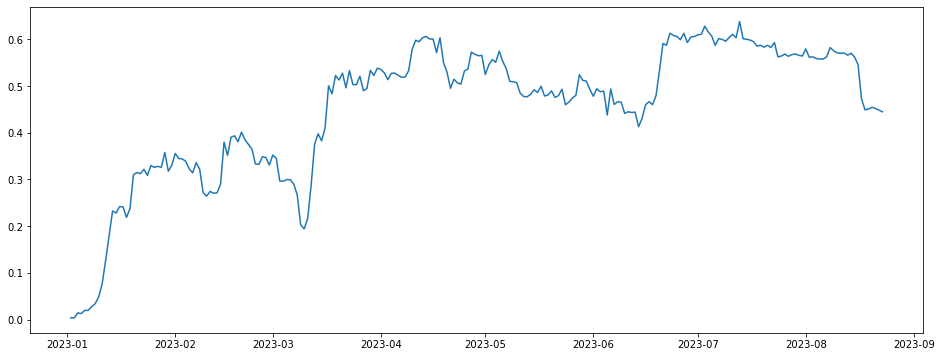

In [9]:
plt.figure(figsize=(16,6))
plt.plot(returns.cumsum())
plt.show()

In [10]:
s

,Close
Date,
2023-01-02 00:00:00+00:00,0.003806
2023-01-03 00:00:00+00:00,-0.000516
2023-01-04 00:00:00+00:00,0.010934
2023-01-05 00:00:00+00:00,-0.001573
2023-01-06 00:00:00+00:00,0.006821
...,...
2023-08-19 00:00:00+00:00,0.001789
2023-08-20 00:00:00+00:00,0.003572
2023-08-21 00:00:00+00:00,-0.002502


In [11]:
def Dias_quedas(data, Close):  
    
    data.reset_index(inplace=True)
    data["Verificando"] = np.nan
    contador = 0
    
    for i in range(len(data[Close])):
        
        if data.loc[i, Close] < 0:
            
            contador += 1
            data.loc[i, "Verificando"] = contador
        
        else:
            
            contador = 0
            data.loc[i, "Verificando"] = 0
            
def Signals(data, nome_coluna, obj_localizado):
    
    data["Signals"] = np.nan
    
    for i in range(len(data[nome_coluna])):
        
        if data.loc[i, nome_coluna] == obj_localizado:
            
            data.loc[i, "Signals"] = True
        else:
            data.loc[i, "Signals"] = False

In [12]:
#data.reset_index(inplace=True)
Dias_quedas(data=retornos, Close="Close")
Signals(data=retornos, nome_coluna="Verificando", obj_localizado=3)

In [13]:
retornos.columns = ["Data", "Close", "Verificando", "Signals"]

In [14]:
retornos[["Verificando", "Signals"]].value_counts()

Verificando  Signals
0.0          False      112
1.0          False       65
2.0          False       25
3.0          True        17
4.0          False        7
5.0          False        5
6.0          False        1
7.0          False        1
8.0          False        1
Name: count, dtype: int64

In [15]:
retornos.set_index("Data", inplace=True)

In [16]:
retornos

,Close,Verificando,Signals
Data,,,
2023-01-02 00:00:00+00:00,0.003806,0.0,False
2023-01-03 00:00:00+00:00,-0.000516,1.0,False
2023-01-04 00:00:00+00:00,0.010934,0.0,False
2023-01-05 00:00:00+00:00,-0.001573,1.0,False
2023-01-06 00:00:00+00:00,0.006821,0.0,False
...,...,...,...
2023-08-19 00:00:00+00:00,0.001789,0.0,False
2023-08-20 00:00:00+00:00,0.003572,0.0,False
2023-08-21 00:00:00+00:00,-0.002502,1.0,False


In [17]:
retornos

,Close,Verificando,Signals
Data,,,
2023-01-02 00:00:00+00:00,0.003806,0.0,False
2023-01-03 00:00:00+00:00,-0.000516,1.0,False
2023-01-04 00:00:00+00:00,0.010934,0.0,False
2023-01-05 00:00:00+00:00,-0.001573,1.0,False
2023-01-06 00:00:00+00:00,0.006821,0.0,False
...,...,...,...
2023-08-19 00:00:00+00:00,0.001789,0.0,False
2023-08-20 00:00:00+00:00,0.003572,0.0,False
2023-08-21 00:00:00+00:00,-0.002502,1.0,False


In [18]:
ticker_data.reset_index(inplace=True)

In [22]:
entries = retornos["Signals"]
data = retornos["Close"]

In [20]:
data.vbt.drop_levels(-1, inplace=True)

In [27]:
retornos

,Close,Verificando,Signals,Trades
Data,,,,
2023-01-02 00:00:00+00:00,0.003806,0.0,False,NaN
2023-01-03 00:00:00+00:00,-0.000516,1.0,False,NaN
2023-01-04 00:00:00+00:00,0.010934,0.0,False,NaN
2023-01-05 00:00:00+00:00,-0.001573,1.0,False,NaN
2023-01-06 00:00:00+00:00,0.006821,0.0,False,NaN
...,...,...,...,...
2023-08-19 00:00:00+00:00,0.001789,0.0,False,NaN
2023-08-20 00:00:00+00:00,0.003572,0.0,False,NaN
2023-08-21 00:00:00+00:00,-0.002502,1.0,False,NaN


In [26]:
retornos["Trades"] = np.nan
for i in range(len(retornos)):
    if retornos.loc[i, "Signals"] == True:
        retornos.loc[i, "Trades"] = ticker_data.loc[i, "Close"]
    else:
        retornos.loc[i, "Trades"] = 15000

KeyError: 0

In [ ]:
retornos["Trades"].unique()

In [ ]:
plt.figure(figsize=(16,6))

plt.plot(ticker_data["Close"])

plt.plot(retornos["Trades"], color="black")

plt.show()